In [44]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import e
connection = sqlite3.connect('file:database.db?mode=ro', uri=True)

market_orders = pd.read_sql_query("SELECT * FROM market_orders", connection)
market_history = pd.read_sql_query("SELECT * FROM market_history", connection)

connection.close()

In [59]:
def pandas_entropy(column, base=None):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

In [45]:
item_34 = market_history.loc[market_history['item_id'] == 17715]
item_34

,id,date,item_id,region_id,low_price,high_price,average_price,order_count,volume
1257410,1257411,2022-09-01,17715,10000002,248500000.0,249400000.0,2.488000e+08,155,164
1257411,1257412,2022-09-02,17715,10000002,255100000.0,260000000.0,2.598000e+08,158,170
1257412,1257413,2022-09-03,17715,10000002,240800000.0,259500000.0,2.589000e+08,174,203
1257413,1257414,2022-09-04,17715,10000002,239000000.0,254600000.0,2.496000e+08,167,183
1257414,1257415,2022-09-05,17715,10000002,249200000.0,250000000.0,2.498000e+08,214,221
...,...,...,...,...,...,...,...,...,...
2550138,2550139,2023-09-28,17715,10000043,282250000.0,312700000.0,3.104889e+08,18,18
2550139,2550140,2023-09-29,17715,10000043,313100000.0,317800000.0,3.144722e+08,18,18
2550140,2550141,2023-09-30,17715,10000043,292100000.0,317400000.0,3.111733e+08,15,15
2550141,2550142,2023-10-01,17715,10000043,283550000.0,316300000.0,2.963381e+08,21,21


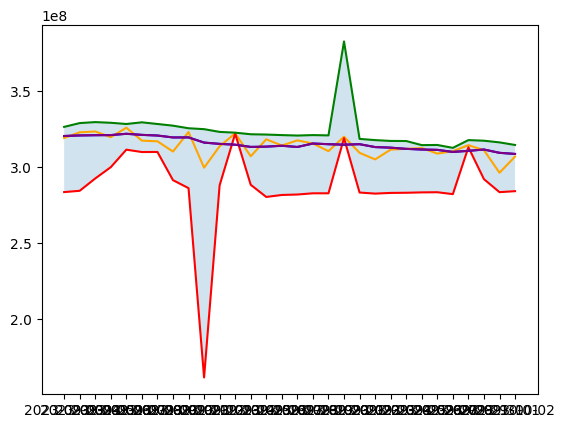

In [57]:
last_30_days = item_34.tail(30)
rolling_7 = item_34['average_price'].rolling(7).mean().tail(30)
rolling_30 = item_34['average_price'].rolling(7).mean().tail(30)

print(pandas_entropy(last_30_days['average_price']))
print(pandas_entropy(rolling_7))
print(pandas_entropy(rolling_30))
plt.figure()
plt.plot(last_30_days['date'], last_30_days['average_price'], label='average_price', color='orange')
plt.plot(last_30_days['date'], last_30_days['low_price'], label='average_price', color='red')
plt.plot(last_30_days['date'], last_30_days['high_price'], label='average_price', color='green')
plt.plot(last_30_days['date'], rolling_7, label='average_price', color='blue')
plt.plot(last_30_days['date'], rolling_30, label='average_price', color='purple')

plt.fill_between(last_30_days['date'], last_30_days['low_price'], last_30_days['high_price'], alpha=0.2)

plt.show()

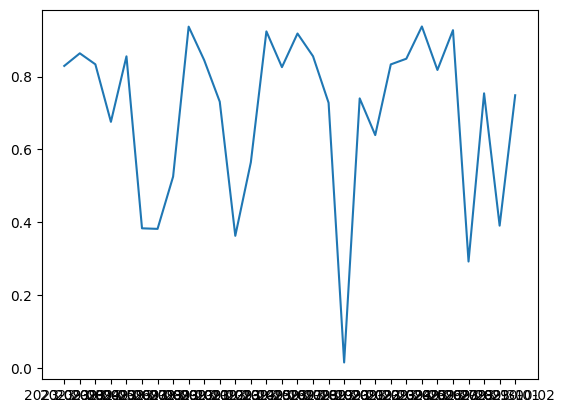

In [47]:
last_30_days = item_34.tail(30)
difference = last_30_days['high_price'] - last_30_days['low_price']
relative_to_low = last_30_days['average_price'] - last_30_days['low_price']
relative = relative_to_low / difference
plt.figure()

# plt.plot(last_30_days['date'], difference, label='average_price')
plt.plot(last_30_days['date'], relative, label='average_price')

plt.show()

3.401197381662155
